In [163]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ast import literal_eval
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
import sympy as sym
from sympy.parsing import mathematica

In [164]:
plt.rcParams['text.usetex'] = False

In [165]:

RESULTS_DIR = "final_results"
benchmarks = [
    "rational/plain",
    "rational_2/plain",
    "sqrt/plain",
    "rational_sqrt/plain",

    "rational/with_constant",
    "rational_2/with_constant",
    "sqrt/with_constant",
    "rational_sqrt/with_constant",
]

In [166]:
def process_output(row):
    if pd.isnull(row):
        return (None, None)

    try:
        row = float(row)
        return (row, row)
    except:
        pass

    try:
        return literal_eval(str(row).strip())
    except Exception as e:
        pass
    
    try:
        for w in ['integrate', 'boole']:
            if w in row.lower():
                return (None, None)        
        
        row = row.replace("[",'(').replace("]", ")").replace("L", "l").replace("E(p_) =", "").replace("^", "**").strip()
        row = sym.parse_expr(row).evalf()
        
        return (row,row)
        
    except Exception as e:
        print(e, row)
    
        
    return (None, None)

In [167]:
def process_time(row):
    if pd.isnull(row):
        return None

    try:
        row = float(row)
        return row
    except:
        pass

    try:
        return literal_eval(str(row).strip())[0]
    except Exception as e:
        pass
        
    except Exception as e:
        print(e, row)
    
        
    return None

In [168]:
def process_benchmark(benchmark):
    df_list = []
    for f_name in os.listdir(os.path.join(RESULTS_DIR, benchmark)):
        tool_name =  f_name.split("_")[-2]
        df_ = pd.read_csv(os.path.join(RESULTS_DIR, benchmark, f_name))
        df_['tool'] = tool_name
        df_list.append(df_[['index', 'tool','output', 'time']])
    df = pd.concat(df_list, ignore_index=True)

    df['output'] = df['output'].apply(process_output)
    df['time'] = df['time'].apply(process_time)
    
    df['lower'], df['upper'] = df['output'].apply(lambda o: o[0]),df['output'].apply(lambda o: o[1])
    df['error'] = df['upper']-df['lower']
    df['error_norm'] = MinMaxScaler().fit_transform(df['error'].values.reshape(-1,1))
    df['benchmark'] = benchmark
    df['is_solved'] = (~pd.isnull(df['error']))&(df['time']<=3600)
    return df

In [169]:
df_b_list = []
for b in benchmarks:
    df_b_list.append(process_benchmark(b))

df_b = pd.concat(df_b_list)
df_b.head()

,index,tool,output,time,lower,upper,error,error_norm,benchmark,is_solved
0,0,faza,"(0.6209815507002485, 0.7190312692318667)",95.899110,0.620982,0.719031,0.09805,0.009178,rational/plain,True
1,1,faza,"(1.3035252399983923, 1.4021111825192791)",2.971019,1.303525,1.402111,0.098586,0.009228,rational/plain,True
2,2,faza,"(0, 0.016205584149650985)",11.460795,0,0.016206,0.016206,0.001517,rational/plain,True
3,3,faza,"(0.47723272447183107, 0.5754865206866198)",16.182557,0.477233,0.575487,0.098254,0.009197,rational/plain,True
4,4,faza,"(1.0119278375331635, 1.1080609820988139)",17.220680,1.011928,1.108061,0.096133,0.008998,rational/plain,True


In [170]:
bench = "rational_sqrt/with_constant"
# df_ = df_b[(df_b.benchmark == bench)&(df_b.tool=='latte')]
df_ = df_b[(df_b.benchmark == bench)]
df_ = df_.sort_values('index')
df_

,index,tool,output,time,lower,upper,error,error_norm,benchmark,is_solved
0,0,gubpi,"(2.7073900080233577, 3.637096713277724)",0.422853,2.70739,3.637097,0.929707,0.163089,rational_sqrt/with_constant,True
120,0,psi,"(None, None)",0.059371,None,None,NaN,NaN,rational_sqrt/with_constant,False
30,0,volesti,"(None, None)",0.000173,None,None,NaN,NaN,rational_sqrt/with_constant,False
90,0,faza,"(3.220172517285123, 3.319950488730202)",302.565481,3.220173,3.31995,0.099778,0.017503,rational_sqrt/with_constant,True
60,0,latte,"(None, None)",0.000042,None,None,NaN,NaN,rational_sqrt/with_constant,False
...,...,...,...,...,...,...,...,...,...,...
119,29,faza,"(2.9903118672318403, 3.0901160685829026)",43.037567,2.990312,3.090116,0.099804,0.017508,rational_sqrt/with_constant,True
59,29,volesti,"(None, None)",0.000043,None,None,NaN,NaN,rational_sqrt/with_constant,False
29,29,gubpi,"(2.5685718777438002, 3.380520752066699)",0.416057,2.568572,3.380521,0.811949,0.142432,rational_sqrt/with_constant,True
89,29,latte,"(None, None)",0.000069,None,None,NaN,NaN,rational_sqrt/with_constant,False


In [171]:
colors = sns.color_palette()

y_pos = {
    "faza": 0.75,
    "gubpi": 0.5,
    "volesti": 0.25,
    "latte":0.5,
    "psi": 0.5
}

color_map = {
    'faza': colors[2], #green
    'gubpi': colors[1], #Orange
    'volesti': colors[3], #red
    'latte': colors[5], # Yellow
    'psi': colors[4],#Pink    
}

marker_map = {
    'faza': None, 
    'gubpi': None, 
    'volesti': None, 
    'latte': "|",
    'psi': "|",    
}

bench_template_map = {
    "rational/plain": r'$\frac{a_i * {x^n}}{b_i * {x^m}}$',
    "rational_2/plain": r'$\frac{a_5 * {x^2} + a_4*{y^2} + a_3*{x*y} + a_2*{x} + a_1*{y} + a_0}{b_5*{x^2} + b_4*{y^2} + b_3*{x*y} + b_2*{x} + b_1*{y} + b_0}$',
    "sqrt/plain": r'$\sqrt{a_i * {x^n}}$',
    "rational_sqrt/plain": r'$\sqrt{\frac{a_i * {x^n}}{b_i * {x^m}}}$',
    "rational/with_constant": r'$c*(\frac{a_i * {x^n}}{b_i * {x^m}})$',
    "rational_2/with_constant": r'$c*(\frac{a_5 * {x^2} + a_4*{y^2} + a_3*{x*y} + a_2*{x} + a_1*{y} + a_0}{b_5*{x^2} + b_4*{y^2} + b_3*{x*y} + b_2*{x} + b_1*{y} + b_0})$',
    "sqrt/with_constant": r'$\sqrt{c*(a_i * {x^n})}$',
    "rational_sqrt/with_constant": r'$\sqrt{c*(\frac{a_i * {x^n}}{b_i * {x^m}})}$',
    
    
    
}

bench_title_map = {
    "rational/plain": "Rational functions",
    "rational_2/plain": "Rational functions (2 vars)",
    "sqrt/plain": "Square root functions",
    "rational_sqrt/plain": "Square root and rational functions",
    "rational/with_constant": "Rational functions (with constant)",
    "rational_2/with_constant": "Rational functions (2 vars, with constant)",
    "sqrt/with_constant": "Square root functions (with constant)",
    "rational_sqrt/with_constant": "Square root and rational functions (with constant)",
    
}

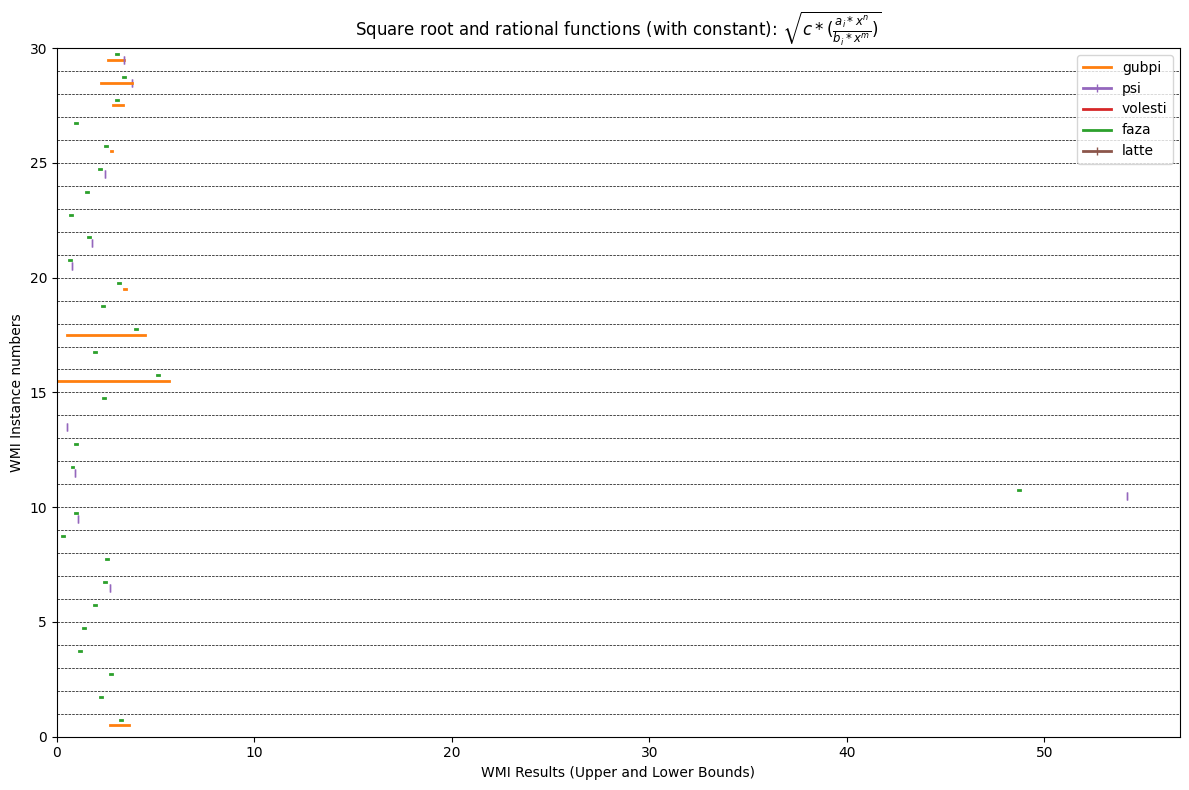

In [172]:
plt.figure(figsize=(12,8))

examples_count = df_.groupby(['benchmark', 'index']).ngroups

# # Put example lines
for i in range(examples_count):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)

for i, row in df_.iterrows():
    plt.plot([row['lower'],row['upper']],[row['index']+y_pos[row['tool']],row['index']+y_pos[row['tool']]], color=color_map[row['tool']], linewidth=2, label=row['tool'], marker=marker_map[row['tool']])

plt.ylim((0,examples_count))
plt.xlim((0,None))

plt.xlabel('WMI Results (Upper and Lower Bounds)')
plt.ylabel('WMI Instance numbers')
plt.title(f"{bench_title_map[bench]}: {bench_template_map[bench]}")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'plots', f"{bench}.jpg".replace("/", '_')), dpi=500)